# Filtering the Proteoimics data with respect to metadata

In this notebook and RNA-Seq.ipynb, the available data is tested against their predictive power of metadata using the random forest classifier. Two rounds of classification with binary target variables is performed, with one having gender as the target,  and the other having the msi tumor characteristic as the target variable.

In [1]:
!ls
#######################################################################

Gender Visual.ipynb   Proteomics.ipynb      preprocess.py
Import.ipynb          RNA-Seq Final.ipynb   raw_data
MSI Visual.ipynb      RNA-Seq.ipynb
NA with RNA-Seq.ipynb __pycache__


In [2]:
import sys
import os
from IPython.utils import io
from io import StringIO

import re
import csv

import pandas as pd
import numpy as np
import scipy 
from scipy.cluster import hierarchy as hc # for dendograms 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# %matplotlib notebook

from sklearn.metrics import f1_score # f1_score(y_true, y_pred)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel

## Import & show data 

The initial data proprocess was done in the Import.ipynb notebook. The following three steps are performed in all other jupyter notebooks: run the preprocess.py code that was generated in Import.ipynb, run the %whos magic command to see what dataframes have been imported, and then format the captured %who results with pandas to view results. #### show the imported dataframes

In [4]:
%run preprocess.py
# made in Import.ipynb

In [5]:
with io.capture_output() as captured:
    %whos DataFrame 

s = re.findall(r'\S+|\n', StringIO(captured.stdout).getvalue())

In [6]:
table = []
row = []

for item in s:
    if (item == '\n'):
        if (row):
            table.append(row)
        row = []
    elif re.match('^(?!-)', item) is None:
        pass        
    else: 
        row.append(item)

for item in table: 
    if (item[0] == 'Variable'):
        pass
    else:
        item[2:] = [' , '.join(item[2:])]

df = pd.DataFrame(data=table[1:], columns=table[0])
pd.set_option('display.max_colwidth', -1)
df

,Variable,Type,Data/Info
0,df_test_cli,DataFrame,"sample , gender , <...>g_80 , Female , MSI-High"
1,df_test_pro,DataFrame,"A1BG , <...>n[80 , rows , x , 4118 , columns]"
2,df_test_rna,DataFrame,"A1BG , A1B<...>[80 , rows , x , 17447 , columns]"
3,df_train_cli,DataFrame,"sample , gender , <...>g_80 , Female , MSI-Low/MSS"
4,df_train_mislabel,DataFrame,"sample , mismatch<...>79 , Training_80 , 1"
5,df_train_pro,DataFrame,"A1BG , <...>n[80 , rows , x , 4118 , columns]"
6,df_train_rna,DataFrame,"A1BG , A1<...>[80 , rows , x , 17447 , columns]"
7,test_cli,DataFrame,"gender , msi\n<...>\nTesting_80 , 1 , 1"
8,test_pro,DataFrame,"A1BG , <...>n[80 , rows , x , 4118 , columns]"
9,test_rna,DataFrame,"A1BG , A1B<...>[80 , rows , x , 17447 , columns]"


In [7]:
# train_pro_combined
# train_rna_combined

## Process

The steps followed for each target are: 

1. Split into train and test sets.
2. Run grid search to find best hyperparameters for random forest classifier. 
3. get rid of less predicitve genes in the dataset, using the variable importance threshhold. 
4. visualize the results and the relations between selected variables with a dendrogram. 

In [8]:
train_combined_correct =\
    train_pro_combined.loc[train_pro_combined['mismatch'] == 0]

X_correct = train_combined_correct.drop(['mismatch'], 
                                        axis=1, 
                                        inplace=False)

X_correct.reset_index(drop=True, inplace=True)

gender_correct = X_correct['gender']
msi_correct = X_correct['msi']
X_correct = X_correct.drop(['gender', 'msi'], axis=1, inplace=False)

columns = X_correct.columns

In [9]:
# X_correct
# gender_correct
# msi_correct

In [10]:
X_gender_train, X_gender_valid, y_gender_train, y_gender_valid =\
\
    train_test_split(X_correct.values.astype(int),
                     gender_correct, 
                     test_size=0.3)

In [11]:
# X_train
# X_valid
# y_train
# y_valid

In [12]:
forest = RandomForestClassifier(n_estimators=500, 
                                n_jobs=-1, 
                                oob_score=True)

# sorted(forest.get_params().keys())

gs = GridSearchCV(estimator=forest,
                  param_grid=[
                      {'min_samples_leaf':[1, 3, 5, 10, 25, 100], 
                       'max_features':[None, 0.5, 'sqrt', 'log2']}],
                  scoring='accuracy',
                  cv=5,)

gs = gs.fit(X_gender_train, y_gender_train)
print(gs.best_score_)
print(gs.best_params_)

0.6595744680851063
{'max_features': 'sqrt', 'min_samples_leaf': 1}


 1) GADD45GIP1                     0.068711
 2) APPL1                          0.026492
 3) AP1M2                          0.019410
 4) SNRPA                          0.019239
 5) PPP1CC                         0.019054
 6) MRPL16                         0.017397
 7) IKBIP                          0.017051
 8) PAPSS1                         0.015874
 9) SRPK1                          0.015611
10) DNM3                           0.015124
11) MAT2B                          0.010842
12) TAF15                          0.010392
13) WDR43                          0.009728
14) TPD52                          0.009361
15) ACOT9                          0.007391
16) GAK                            0.007318
17) SERPINA6                       0.007028
18) DAP                            0.006953
19) IGLL5                          0.006681
20) NAP1L1                         0.006628
21) XPNPEP1                        0.006576
22) FAM3D                          0.006197
23) RPL39                       

<BarContainer object of 4118 artists>

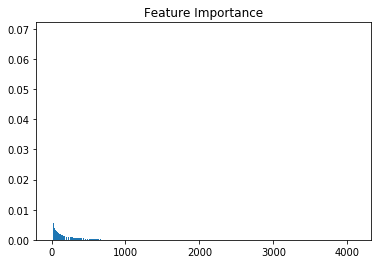

In [13]:
gender_forest = RandomForestClassifier(n_estimators=500,
                                min_samples_leaf=3,
                                max_features=None,
                                n_jobs=-1, 
                                oob_score=True)
gender_forest.fit(X_gender_train, y_gender_train)

gender_importances = gender_forest.feature_importances_
gender_indices = np.argsort(gender_importances)[::-1]

# for f in range(X_gender_train[1]): # to get the full results
for f in range(100):
    print("%2d) %-*s %f" % (f + 1, 
                            30, 
                            columns[gender_indices[f]], 
                            gender_importances[gender_indices[f]]))
    
plt.title('Feature Importance')

plt.bar(range(X_gender_train.shape[1]), 
        gender_importances[gender_indices], 
        align='center')

In [14]:
y_gender_pred = gender_forest.predict(X_gender_valid)
print('k=5 Nearest Neighbors: \n', 
      classification_report(y_true=y_gender_valid, y_pred=y_gender_pred))
print('OOB score: ', gender_forest.oob_score_)

k=5 Nearest Neighbors: 
              precision    recall  f1-score   support

          0       1.00      0.38      0.55         8
          1       0.72      1.00      0.84        13

avg / total       0.83      0.76      0.73        21

OOB score:  0.5106382978723404


In [16]:
gender_select = SelectFromModel(gender_forest, threshold=0.005)

gender_select.fit(X_gender_train, y_gender_train)

X_gender_important_train = gender_select.transform(X_gender_train)
X_gender_important_train_df = pd.DataFrame(X_gender_important_train)
X_gender_important_valid = gender_select.transform(X_gender_valid)

In [17]:
gender_forest.fit(X_gender_important_train, y_gender_train)
y_pred = gender_forest.predict(X_gender_important_valid)
print('k=5 Nearest Neighbors: \n', 
      classification_report(y_true=y_gender_valid, y_pred=y_gender_pred))
print('OOB score: ', gender_forest.oob_score_)

k=5 Nearest Neighbors: 
              precision    recall  f1-score   support

          0       1.00      0.38      0.55         8
          1       0.72      1.00      0.84        13

avg / total       0.83      0.76      0.73        21

OOB score:  0.723404255319149


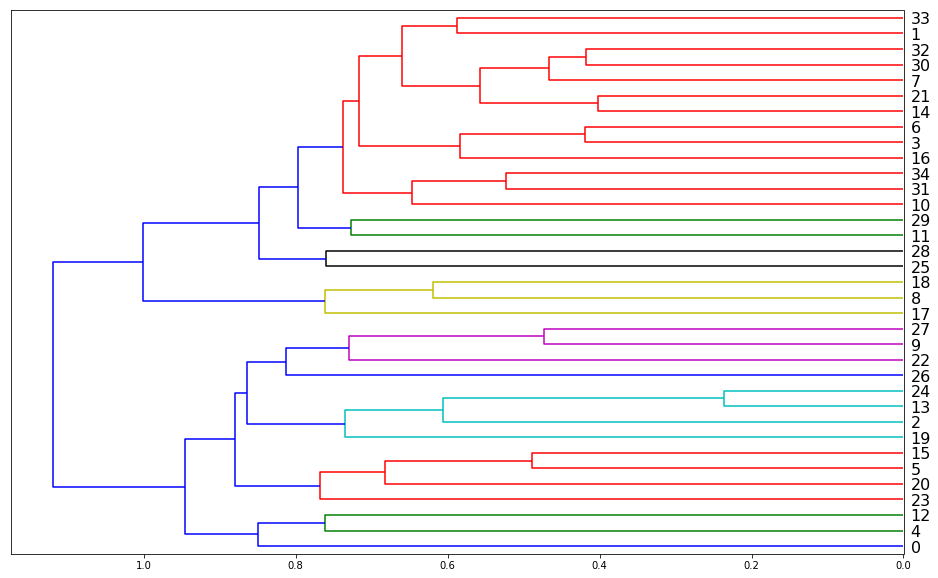

In [18]:
gender_corr = np.round(
            scipy.stats.spearmanr(X_gender_important_train).correlation
                   , 4)

gender_corr_condensed = hc.distance.squareform(1-gender_corr)

z = hc.linkage(gender_corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))

gender_dendrogram = hc.dendrogram(
                z, 
                labels=X_gender_important_train_df.columns, 
                orientation='left', 
                leaf_font_size=16)
plt.show()

In [19]:
X_msi_train, X_msi_valid, y_msi_train, y_msi_valid =\
\
    train_test_split(X_correct.values.astype(int),
                     msi_correct,
                     test_size=0.3)

In [20]:
forest = RandomForestClassifier(n_estimators=500, 
                                n_jobs=-1, 
                                oob_score=True)

# sorted(forest.get_params().keys())

gs = GridSearchCV(estimator=forest,
                  param_grid=[{'min_samples_leaf':[1, 3, 5, 10, 25, 100], 
                               'max_features':[None, 0.5, 'sqrt', 'log2']}],
                  scoring='accuracy',
                  cv=5,)

gs = gs.fit(X_msi_train, y_msi_train)
print(gs.best_score_)
print(gs.best_params_)

 1) CASK                           0.168726
 2) UBE2L6                         0.100945
 3) PTPRC                          0.077407
 4) MANF                           0.058642
 5) TAP1                           0.053728
 6) IFI30                          0.037353
 7) GBP1                           0.027853
 8) TAPBP                          0.018825
 9) ATOX1                          0.018200
10) PLEK                           0.017939
11) ADPGK                          0.017926
12) ACSL5                          0.017626
13) LSP1                           0.017033
14) DLG1                           0.016146
15) TYMP                           0.014558
16) CKB                            0.013136
17) CD74                           0.010848
18) HP                             0.010013
19) ATP6V1B2                       0.009437
20) KLC4                           0.008982
21) SNX12                          0.008713
22) IFI35                          0.008527
23) MARCKSL1                    

<BarContainer object of 4118 artists>

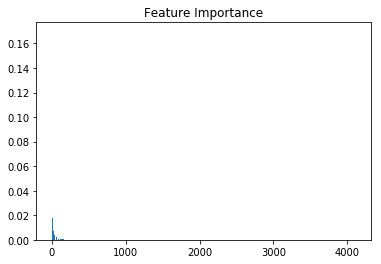

In [21]:
msi_forest = RandomForestClassifier(n_estimators=500,
                                min_samples_leaf=5,
                                max_features=None,
                                n_jobs=-1, 
                                oob_score=True)

msi_forest.fit(X_msi_train, y_msi_train)

msi_importances = msi_forest.feature_importances_
msi_indices = np.argsort(msi_importances)[::-1]

# for f in range(X_train.shape[1]): # to get the full results
for f in range(100):
    print("%2d) %-*s %f" % (f + 1, 
                            30, 
                            columns[msi_indices[f]], 
                            msi_importances[msi_indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_msi_train.shape[1]), 
        msi_importances[msi_indices], 
        align='center')

In [22]:
y_msi_pred = msi_forest.predict(X_msi_valid)

print('k=5 Nearest Neighbors: \n', 
      classification_report(y_true=y_msi_valid, y_pred=y_msi_pred))

print('OOB score: ', msi_forest.oob_score_)

k=5 Nearest Neighbors: 
              precision    recall  f1-score   support

          0       0.89      0.94      0.92        18
          1       0.50      0.33      0.40         3

avg / total       0.84      0.86      0.84        21

OOB score:  0.7872340425531915


In [23]:
msi_select = SelectFromModel(msi_forest, threshold=0.005)

msi_select.fit(X_msi_train, y_msi_train)

X_msi_important_train = msi_select.transform(X_msi_train)
X_msi_important_train_df = pd.DataFrame(X_msi_important_train)
X_msi_important_valid = msi_select.transform(X_msi_valid)

In [24]:
msi_forest.fit(X_msi_important_train, y_msi_train)
y_msi_pred = msi_forest.predict(X_msi_important_valid)
print('k=5 Nearest Neighbors: \n', 
      classification_report(y_true=y_msi_valid, 
                            y_pred=y_msi_pred))

print('OOB score: ', msi_forest.oob_score_)

k=5 Nearest Neighbors: 
              precision    recall  f1-score   support

          0       0.89      0.94      0.92        18
          1       0.50      0.33      0.40         3

avg / total       0.84      0.86      0.84        21

OOB score:  0.851063829787234


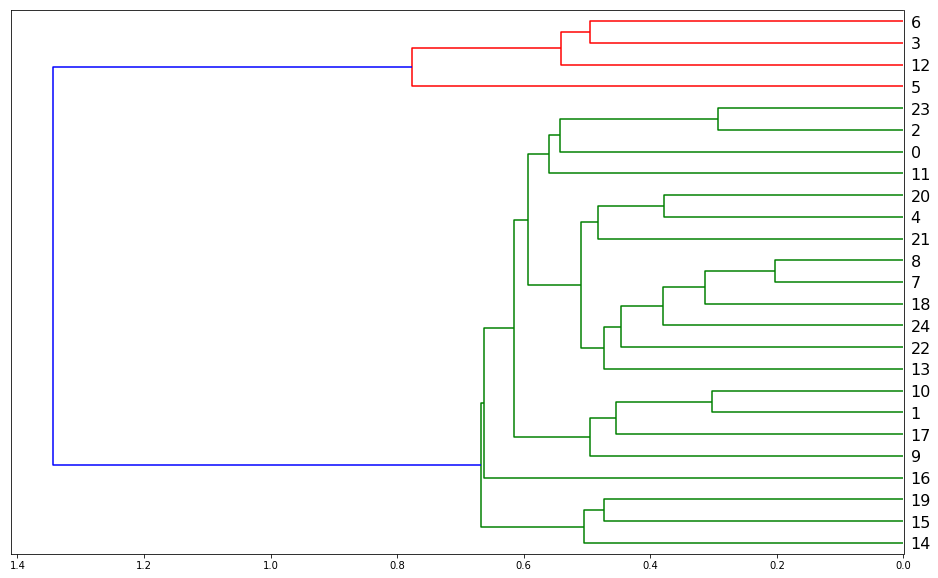

In [25]:
msi_corr = np.round(scipy.stats.spearmanr(X_msi_important_train).correlation, 4)
msi_corr_condensed = hc.distance.squareform(1-msi_corr)
msi_z = hc.linkage(msi_corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
msi_dendrogram = hc.dendrogram(msi_z, labels=X_msi_important_train_df.columns, orientation='left', leaf_font_size=16)
plt.show()